<a href="https://colab.research.google.com/github/luizrenault/snrmodel/blob/main/ss_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from matplotlib.gridspec import GridSpec
from ipywidgets import IntProgress
from IPython.display import display


System Parameters

In [15]:
class ParameterInfo:
    def __init__(self, default, variation, xlabel, description=None, xticks=None, simulate=False):
        self.default = default
        self.variation = variation
        self.xlabel = xlabel
        self.description = description
        self.xticks = xticks
        self.simulate = simulate

parameter_infos = {}

parameter_infos['meanK'] = ParameterInfo(
    default=1.88,
    variation=np.linspace(-10, 10, 8),
    xlabel="Mean Rice factor, $\mu_K$, in dB",
    description="Mean of Rice factor (dB) for variable K over the runs and SUs.",
    xticks=np.arange(-10, 11, 5),
)

parameter_infos['sdK'] = ParameterInfo(
    default=4.13,
    variation=np.linspace(0, 10, 8),
    xlabel="Rice factor std. dev., $\sigma_K$, in dB",
    description="Standard deviation (dB) of K over the runs and SUs.",
    xticks=None
)

parameter_infos['randK'] = ParameterInfo(
    default=True,
    variation=[True, False],
    xlabel="Random Rice factor, $randK$",
    description="If randK, K is random; otherwise, K = meanK.",
    xticks=None
)

parameter_infos['m'] = ParameterInfo(
    default=5,
    variation=[2, 5, 10, 16, 20, 25],
    xlabel="Number of SUs, $m$",
    description="Number of SU receivers (m = 1 for NCSS or M > 1 for CSS).",
    xticks=np.arange(0, 26, 5),
)
parameter_infos['eta'] = ParameterInfo(
    default=2.5,
    variation=np.linspace(1, 4, 8),
    xlabel="Path loss exponent, $\eta$",
    description="Path-loss exponent.",
    xticks=None
)
parameter_infos['n'] = ParameterInfo(
    default=400,
    variation=[192, 368, 544, 720, 896, 1072, 1248, 1600],
    xlabel="Number of samples, $n$",
    description="Number of samples per SU.",
    xticks=np.arange(0, 1601, 400)
)
parameter_infos['SNR'] = ParameterInfo(
    default=-5,
    variation=np.linspace(-15, 5, 8),
    xlabel="SNR in dB",
    description="Average signal-to-noise ratio over all SUs, dB.",
    xticks=None,
)
parameter_infos['rho'] = ParameterInfo(
    default=0.5,
    variation=[0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99],
    xlabel=r"Fraction $\rho$",
    description="Fraction of noise power variations about the mean.",
    xticks=np.arange(0, 1.2, 0.2),
)
parameter_infos['Ns'] = ParameterInfo(
    default=15,
    variation=np.ones(11, np.integer),
    xlabel="Samples per QPSK symbol, $N_s$",
    description="Number of samples per QPSK PU symbol.",
    xticks=np.arange(0, 221, 20)
)
parameter_infos['E'] = ParameterInfo(
    default=0.1,
    variation=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
    xlabel="Inequality aversion of AID, $\epsilon$",
    description="Inequality aversion parameter of the AID.",
    xticks=None
)
parameter_infos['sigma_s'] = ParameterInfo(
    default=7,
    variation=np.linspace(0, 15, 8),
    xlabel="Shadowing standard deviation, $\sigma_s$",
    description="Standard deviation of the Shadowing, dB.",
    xticks=None
)

parameter_infos['rows'] = ParameterInfo(
    default=50,
    variation=[50],
    xlabel="Shadowing Matrix Rows",
    description="Number of rows of the full shadowing matrix."
)

parameter_infos['Lambda'] = ParameterInfo(
    default=25,
    variation=np.linspace(1, parameter_infos['rows'].default-10, 8),
    xlabel="Shadowing correlation length, $\Lambda$",
    description="Correlation length (Lambda is a fraction of the number of rows of the full shadowing matrix).",
    xticks=np.arange(0, parameter_infos['rows'].default-9, 10)
)

parameter_infos['r'] = ParameterInfo(
    default=1000,
    variation=np.linspace(100, 1000, 8),
    xlabel="Operation Area Radius, $r$ (m)",
    description="Coverage radius, meters.",
    xticks=np.arange(100, 1001, 100)
)

parameter_infos['xPU'] = ParameterInfo(
    default=1000,
    variation=np.linspace(parameter_infos['r'].default, parameter_infos['r'].default*10, 8),
    xlabel="PU tx location ($x=y$) in m",
    description="x-coordinate of the PU tx, m. Equal to y-coordinate.",
    xticks=np.arange(0, parameter_infos['r'].default*10+1, parameter_infos['r'].default*2)
)

parameter_infos['P_txPU'] = ParameterInfo(
    default=5,
    variation=[5],
    xlabel="PU Transmission Power, $P_txPU$ (W)",
    description="PU Transmission Power."
)

parameter_infos['d0'] = ParameterInfo(
    default=1,
    variation=[1],
    xlabel="Reference distance, $d_0$ (m)",
    description="Reference distance."
)

parameter_infos['runs'] = ParameterInfo(
    default=1000,
    variation=[1000],
    xlabel="Number of sensing rounds, $runs$",
    description="Number of sensing rounds to compute empirical CDFs."
)

parameter_infos['Pfa'] = ParameterInfo(
    default=0.1,
    variation=[0.1],
    xlabel="False alarm probability, $P_{fa}$",
    description="Reference Pfa for threshold computation."
)

parameter_infos['L'] = ParameterInfo(
    default=1,
    variation=[1, 2, 4, 8, 16, 32, 64, 128],
    xlabel="Length of moving average filter, $L$",
    description="Length of the moving average filter applied to each SU before DC offset."
)

parameter_infos['SDCR_dB'] = ParameterInfo(
    default=np.inf,
    variation=[-10, -5, 0, 5, 10, 20],
    xlabel="Signal-to-DC-offset ratio (SDCR) [dB]",
    description="Residual DC offset strength relative to signal power. Higher is better."
)

parameter_infos['fod'] = ParameterInfo(
    default=0,
    variation=[0.5, 0.8, 1.0, 1.2, 1.5, 2.0],
    xlabel="Overdrive factor, $f_{od}$",
    description="AGC overdrive factor controlling clipping severity at the ADC."
)

parameter_infos['Nq_bits'] = ParameterInfo(
    default=0,
    variation=[0, 1, 2, 3, 4, 5, 6, 8],
    xlabel="Quantization resolution [bits]",
    description="Number of bits used for quantization of SU samples before transmission to the FC."
)

parameter_infos['clip_range'] = ParameterInfo(
    default=1,
    variation=[0.5, 0.8, 1.0, 1.2, 1.5, 2.0],
    xlabel="Clipping range",
    description="Range for clipping the AGC output."
)


default_parameters = {key: parameter.default for key, parameter in parameter_infos.items()}


<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:81: SyntaxWarning: invalid escape sequence '\e'
<>:88: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\L'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:81: SyntaxWarning: invalid escape sequence '\e'
<>:88: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipython-input-1440135547.py:15: SyntaxWarning: invalid escape sequence '\m'
  xlabel="Mean Rice factor, $\mu_K$, in dB",
/tmp/ipython-input-1440135547.py:23: SyntaxWarning: invalid escape sequence '\s'
  xlabel="Rice factor std. dev., $\sigma_K$, in dB",
/tmp/ipython-input-1440135547.py:46: SyntaxWarning: invalid escape sequence '\e'
  xlabel="Path loss exponent, $\eta$",
/tmp/i

Cognitive Radio Network Simulation Area

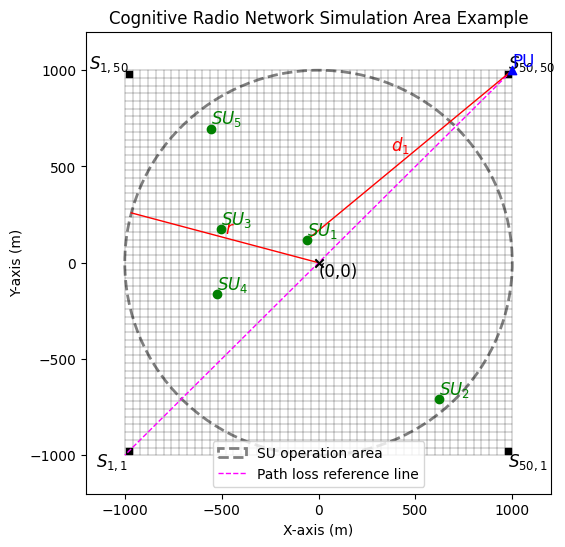

In [16]:
pu_pos = np.array([default_parameters['xPU'], default_parameters['xPU']])

def generate_su(num_users = 10, max_distance_meters = 1000):
    rr = np.sqrt(np.random.rand(num_users))*max_distance_meters
    theta = np.random.rand(num_users)*2*np.pi
    su_pos = np.array([rr*np.cos(theta), rr*np.sin(theta)]).T

    return su_pos

r = default_parameters['r']
rows = default_parameters['rows'] if default_parameters['rows'] > 0 else 50

plt.figure(figsize=(6, 6))  # Set the figure size
plt.gca().add_patch(plt.Circle((0, 0), r, linestyle='--', color='gray', label='SU operation area', fill=False, linewidth=2, zorder=0))
for y in np.linspace(-r, r, rows+1): plt.plot([-r, r], [y, y], color='black', linewidth=0.2)
for x in np.linspace(-r, r, rows+1): plt.plot([x, x], [-r, r], color='black', linewidth=0.2)


plt.text(-r + r/rows, -r + r/rows, f'$S_{{{1},{1}}}$', color='black', fontsize=12, ha='right', va='top', zorder=1, fontweight='bold')
plt.text(-r + r/rows, r - r/rows, f'$S_{{{1},{50}}}$', color='black', fontsize=12, ha='right', va='bottom', zorder=1, fontweight='bold')
plt.text(r - r/rows, -r + r/rows, f'$S_{{{50},{1}}}$', color='black', fontsize=12, ha='left', va='top', zorder=1, fontweight='bold')
plt.text(r - r/rows, r - r/rows, f'$S_{{{50},{50}}}$', color='black', fontsize=12, ha='left', va='bottom', zorder=1, fontweight='bold')

plt.scatter(-r + r/rows, -r + r/rows, color='black', marker='s', s=r/rows, zorder=2)
plt.scatter(-r + r/rows, r - r/rows, color='black', marker='s', s=r/rows, zorder=2)
plt.scatter(r - r/rows, -r + r/rows, color='black', marker='s', s=r/rows, zorder=2)
plt.scatter(r - r/rows, r - r/rows, color='black', marker='s', s=r/rows, zorder=2)

limit = max(r, abs(pu_pos[0]), abs(pu_pos[1]))

plt.xlim(-limit * 1.2, limit * 1.2)
plt.ylim(-limit * 1.2, limit * 1.2)

plt.plot([pu_pos[0], -pu_pos[0]], [pu_pos[1], -pu_pos[1]], color='magenta', linestyle='--', linewidth=1, label='Path loss reference line')
plt.legend(loc='lower center')


plt.scatter(0, 0, color='black', label='Origin (0,0)', zorder=5, marker='x')
plt.text(0, 0, '(0,0)', color='black', fontsize=12, ha='left', va='top')  # Add label near the point

plt.scatter(pu_pos[0], pu_pos[1], color='blue', label='PU (1000,1000)', zorder=5, marker='^')
plt.text(pu_pos[0], pu_pos[1], 'PU', color='blue', fontsize=12, ha='left', va='bottom')

angle_rad = np.deg2rad(165)
x_end = 1000 * np.cos(angle_rad)
y_end = 1000 * np.sin(angle_rad)
plt.plot([0, x_end], [0, y_end], color='red', linestyle='-', linewidth=1, label='$r$')
plt.text(x_end / 2, y_end / 2, '$r$', color='red', fontsize=12, ha='left', va='bottom')

np.random.seed(48)  # For reproducibility

su_pos = generate_su(default_parameters['m'], default_parameters['r'])

plt.scatter(su_pos[:,0], su_pos[:,1], color='green', zorder=5)

for i, su in enumerate(su_pos, start=1):
    plt.text(su[0], su[1], f'$SU_{i}$', color='green', fontsize=12, ha='left', va='bottom')

plt.plot([pu_pos[0], su_pos[0][0]], [pu_pos[1], su_pos[0][1]], color='red', linestyle='-', linewidth=1, label='$d_2$')
plt.text((pu_pos[0] + su_pos[0][0]) / 2, (pu_pos[1] + su_pos[0][1]) / 2, f'$d_1$', color='red', fontsize=12, ha='right', va='bottom')

plt.xlabel('X-axis (m)')
plt.ylabel('Y-axis (m)')
plt.title('Cognitive Radio Network Simulation Area Example')
plt.show()


Primary User Signal

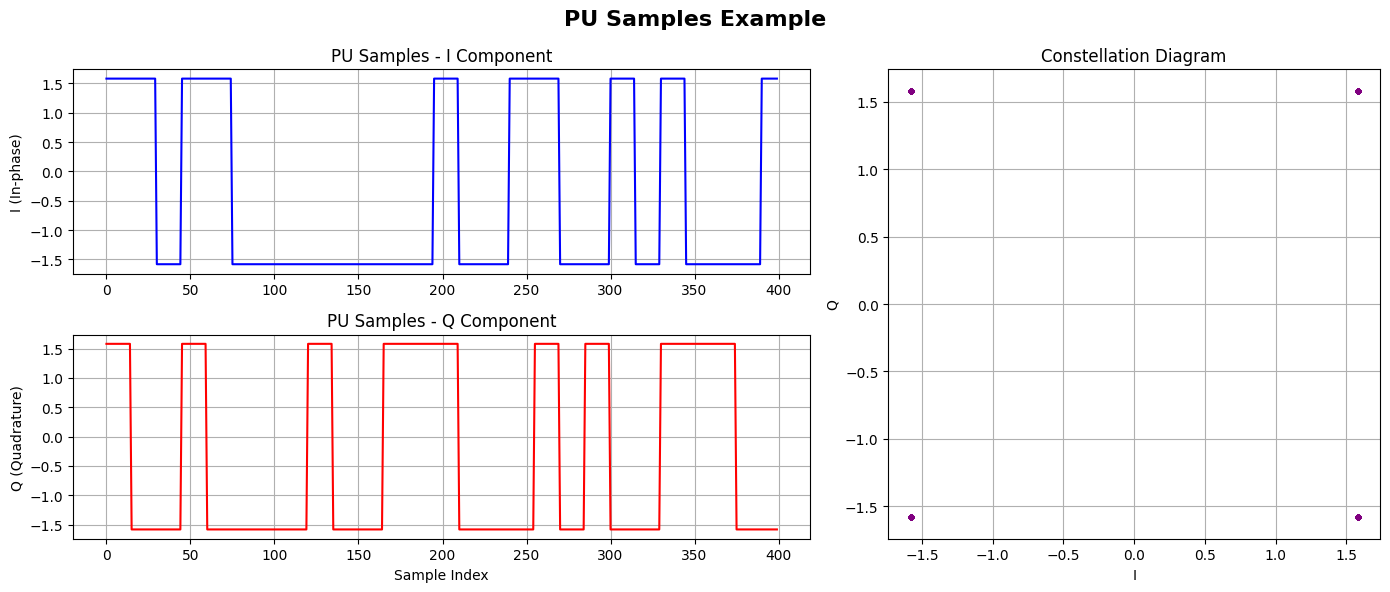

In [17]:
def qpsk(num_samples = 1000, samples_per_symbol = 1):
    num_symbols = int(np.ceil(num_samples/samples_per_symbol))
    x_int = (np.random.randint(0, 4, num_symbols) * np.ones((samples_per_symbol, num_symbols))).T.flatten()
    x_int = x_int[:num_samples]
    x_degrees = x_int*360/4.0 + 45
    x_radians = x_degrees*np.pi/180.0
    x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians)
    x_symbols = np.roll(x_symbols, np.random.randint(0, samples_per_symbol))
    return np.matrix(x_symbols * np.sqrt(2))

pu_samples = qpsk(default_parameters['n'], default_parameters['Ns']) * np.sqrt(default_parameters['P_txPU']/2)

fig = plt.figure(figsize=(14, 6))
gs = GridSpec(2, 2, width_ratios=[3, 2])

# I component (top left)
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(np.real(pu_samples.A1), color='blue')
ax0.set_title('PU Samples - I Component')
ax0.set_ylabel('I (In-phase)')
ax0.grid(True)

# Q component (bottom left)
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(np.imag(pu_samples.A1), color='red')
ax1.set_title('PU Samples - Q Component')
ax1.set_ylabel('Q (Quadrature)')
ax1.set_xlabel('Sample Index')
ax1.grid(True)

# Constellation diagram (right, spans both rows)
ax2 = fig.add_subplot(gs[:, 1])
ax2.scatter(np.real(pu_samples.A1), np.imag(pu_samples.A1), color='purple', s=10, alpha=0.7)
ax2.set_title('Constellation Diagram')
ax2.set_xlabel('I')
ax2.set_ylabel('Q')
ax2.grid(True)

fig.suptitle('PU Samples Example', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

Channel

Log-distance path loss


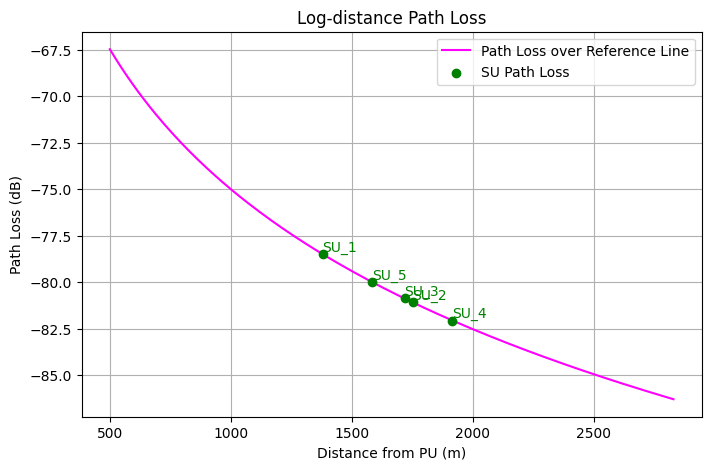

In [18]:
def log_distance_path_loss(d, d0=1, eta=4.5):
    return (d0 / d)**eta

distances = np.linalg.norm(su_pos - pu_pos, axis = 1)

path_losses = log_distance_path_loss(distances, default_parameters['d0'], default_parameters['eta'])

ref_line = np.linspace(500, np.linalg.norm(pu_pos)*2, 200)
ref_path_loss = log_distance_path_loss(ref_line, default_parameters['d0'], default_parameters['eta'])

plt.figure(figsize=(8, 5))
plt.plot(ref_line, 10*np.log10(ref_path_loss), color='magenta', label='Path Loss over Reference Line')
plt.scatter(distances, 10*np.log10(path_losses), color='green', label='SU Path Loss', zorder=5)
for i, (x, y) in enumerate(zip(distances, 10*np.log10(path_losses)), start=1):
    plt.text(x, y, f'SU_{i}', color='green', fontsize=10, ha='left', va='bottom')
plt.xlabel('Distance from PU (m)')
plt.ylabel('Path Loss (dB)')
plt.title('Log-distance Path Loss')
plt.legend()
plt.grid(True)
plt.show()

Shadowing


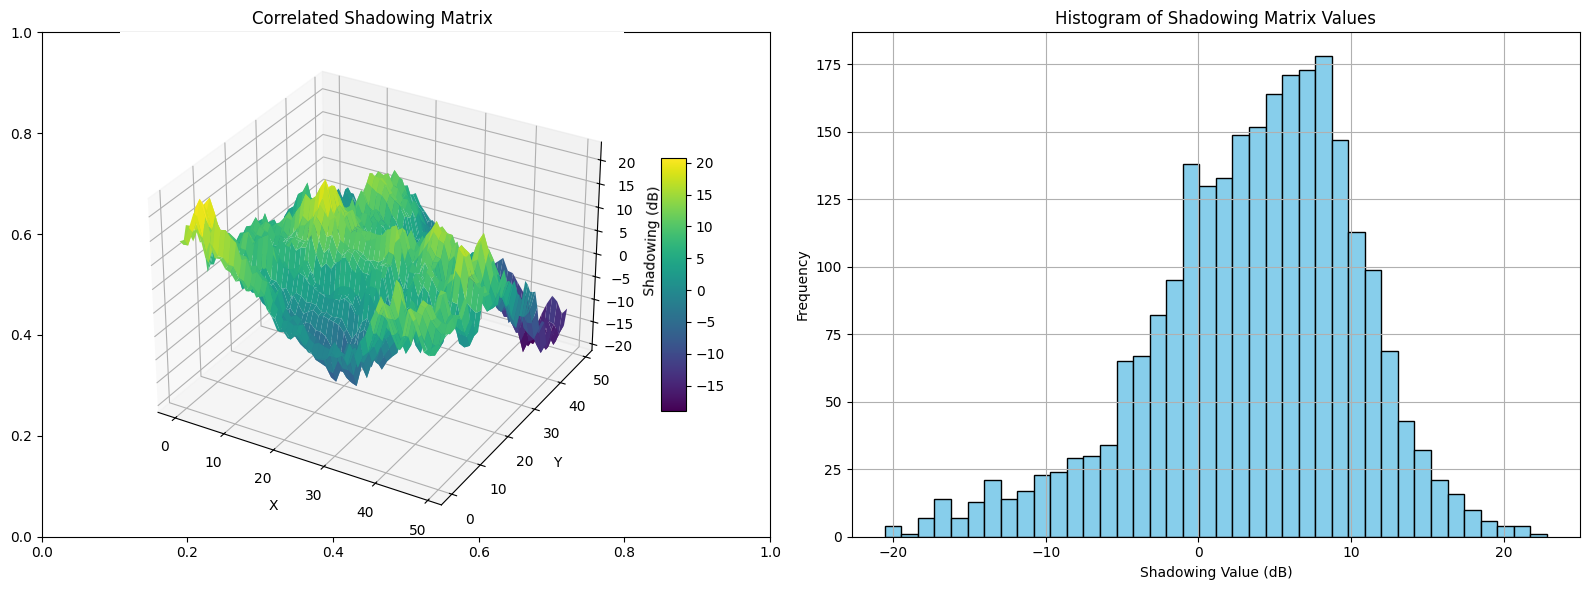

Mean of shadow matrix values: 3.5978270277816518
Standard deviation of shadow matrix values: 6.875157136859849


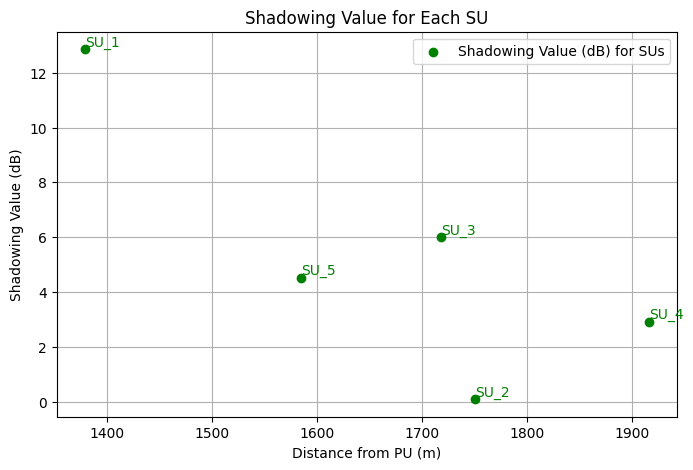

In [19]:
def Shadowing_L_matrix(rows, lambdav):
    # Form the distance matrix
    [X, Y] = np.meshgrid(range(1,rows+1), range(1,rows+1));
    distances = np.sqrt(np.square(X - np.transpose(X)) + np.square(Y - np.transpose(Y)));

    # Compute the correlation matrix based on the negative-exponential model
    correlation_matrix = np.exp(-distances / lambdav);

    # Cholesky decomposition to get the lower triangular matrix
    L = np.linalg.cholesky(correlation_matrix);
    return L

def Shadowing_matrix (rows, sigma_s, L):
    # Generate uncorrelated Gaussian (normal) random matrix
    uncorrelated_matrix = np.random.randn(rows,rows);


    # Multiply the uncorrelated matrix by the Cholesky factor
    correlated_matrix = L @ uncorrelated_matrix @ L.T;

    # Rescale the matrix to have unit variance
    correlated_matrix = sigma_s * correlated_matrix;
    return correlated_matrix

def Extract_shadowing_values(SU, correlated_matrix, r):
    rows = np.sqrt(correlated_matrix.size);

    # Normalize the SU coordinates from [-r, r] to [1, rows]
    SU = np.array(SU)
    SU = (SU + r) / (2*r) * (rows-1) + 1

    # Round the coordinates to the nearest integer for indexing
    SU = np.round(SU);

    # Ensure the indices are within the bounds of the matrix
    SU[SU < 1] = 1; SU[SU > rows] = rows;

    SU=np.array(SU-1, dtype=np.uint32);

    # Extract the values from the correlated_matrix at the specified coordinates
    m_shadowing_values = correlated_matrix[SU[:,0], SU[:,1]];

    return m_shadowing_values;

default_parameters['shadow_L_matrix'] = Shadowing_L_matrix(default_parameters['rows'], default_parameters['Lambda'])

shadow_matrix = Shadowing_matrix(rows, default_parameters['sigma_s'], default_parameters['shadow_L_matrix'])
shadow_values_db = Extract_shadowing_values(su_pos, shadow_matrix, r)
shadow_value = 10**(shadow_values_db/10)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 3D surface plot
ax3d = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(np.arange(rows), np.arange(rows))
surf = ax3d.plot_surface(X, Y, shadow_matrix, cmap='viridis', edgecolor='none')
ax3d.set_title('Correlated Shadowing Matrix')
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Shadowing (dB)')
fig.colorbar(surf, ax=ax3d, shrink=0.5, aspect=10)

# Histogram
axs[1].hist(shadow_matrix.flatten(), bins=40, color='skyblue', edgecolor='black')
axs[1].set_xlabel('Shadowing Value (dB)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Shadowing Matrix Values')
axs[1].grid(True)

plt.tight_layout()
plt.show()

print("Mean of shadow matrix values:", np.mean(shadow_matrix))
print("Standard deviation of shadow matrix values:", np.std(shadow_matrix))

plt.figure(figsize=(8, 5))
plt.scatter(distances, shadow_values_db, color='green', label='Shadowing Value (dB) for SUs', zorder=5)
for i, (d, s_db) in enumerate(zip(distances, shadow_values_db), start=1):
    plt.text(d, s_db, f'SU_{i}', color='green', fontsize=10, ha='left', va='bottom')
plt.xlabel('Distance from PU (m)')
plt.ylabel('Shadowing Value (dB)')
plt.title('Shadowing Value for Each SU')
plt.legend()
plt.grid(True)
plt.show()


Ricean Factor

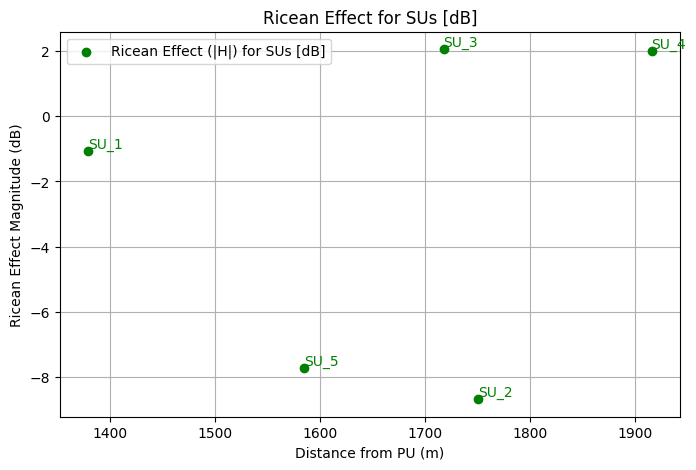

Mean of Ricean Factor (magnitude): 0.837550769311434
Standard deviation of Ricean Factor (magnitude): 0.3913415809917108


In [20]:
def Ricean_Factor(distances, meanK_dB=1.88, sdK_dB=4.13, randomK=True):
    #Complex Rician Random variable
    if randomK:
        K = 10**((np.random.randn(len(distances)) * sdK_dB + meanK_dB)/10)
    else:
        K = 10**((np.ones(len(distances)) * meanK_dB)/10)

    s = np.sqrt(K/(K+1))
    sigma = np.sqrt(1/(2*(K+1))) #Scatter standard deviation

    H = np.random.normal(s, sigma, len(distances)) + 1j*np.random.normal(0, sigma, len(distances)) ###### TODO Check imaginary component MEAN

    return H

H = Ricean_Factor(distances, default_parameters['meanK'], default_parameters['sdK'], default_parameters['randK'])

plt.figure(figsize=(8, 5))
plt.scatter(distances, 20 * np.log10(np.abs(H)), color='green', label='Ricean Effect (|H|) for SUs [dB]', zorder=5)
for i, (d, h_db) in enumerate(zip(distances, 20 * np.log10(np.abs(H))), start=1):
    plt.text(d, h_db, f'SU_{i}', color='green', fontsize=10, ha='left', va='bottom')
plt.xlabel('Distance from PU (m)')
plt.ylabel('Ricean Effect Magnitude (dB)')
plt.title('Ricean Effect for SUs [dB]')
plt.legend()
plt.grid(True)
plt.show()


print("Mean of Ricean Factor (magnitude):", np.mean(np.abs(H)))
print("Standard deviation of Ricean Factor (magnitude):", np.std(np.abs(H)))

Combined channel effect

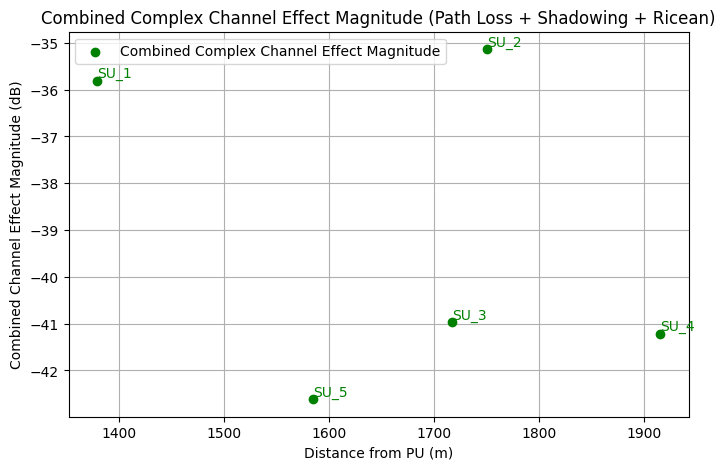

In [21]:
# Combined complex channel effect: path loss * shadowing * Ricean fading (complex)

def get_combined_channel_complex(pu_pos, su_pos, parameters):
    distances = np.linalg.norm(su_pos - pu_pos, axis = 1)
    path_losses = log_distance_path_loss(distances, parameters['d0'], parameters['eta'])
    if parameters['rows'] > 0:
        shadow_values_db = Extract_shadowing_values(su_pos, Shadowing_matrix(parameters['rows'], parameters['sigma_s'], parameters['shadow_L_matrix']), parameters['r'])
        shadow_value = 10**(shadow_values_db/10)
    else:
        shadow_value = np.ones(parameters['m'])
    H = Ricean_Factor(distances, parameters['meanK'], parameters['sdK'], parameters['randK'])
    combined_channel_complex = np.sqrt(path_losses * shadow_value) * H
    return combined_channel_complex

combined_channel_complex = get_combined_channel_complex(pu_pos, su_pos, default_parameters)

plt.figure(figsize=(8, 5))
plt.scatter(distances, 10 * np.log10(np.abs(combined_channel_complex)), color='green', label='Combined Complex Channel Effect Magnitude', zorder=5)

# Add SU names to each point
for i, (x, y) in enumerate(zip(distances, 10 * np.log10(np.abs(combined_channel_complex))), start=1):
    plt.text(x, y, f'SU_{i}', color='green', fontsize=10, ha='left', va='bottom')

plt.xlabel('Distance from PU (m)')
plt.ylabel('Combined Channel Effect Magnitude (dB)')
plt.title('Combined Complex Channel Effect Magnitude (Path Loss + Shadowing + Ricean)')
plt.legend()
plt.grid(True)
plt.show()

Expected average channel effect over the operating area

In [22]:
# Define the integrand function
def integrand(z, theta, pu_pos, parameters):
    # print(f"Integrating at z={z}, theta={theta}")
    su_pos = np.array([z * np.cos(theta), z * np.sin(theta)])
    return log_distance_path_loss(np.linalg.norm(su_pos - pu_pos), parameters['d0'], parameters['eta']) * z

def CalcRXPower(parameters):
    # Integration limits
    theta_min, theta_max = 0, 2 * np.pi
    z_min, z_max = 0, parameters['r']

    # Compute the integral
    integral_value, _ = integrate.dblquad(integrand, theta_min, theta_max, lambda _: z_min, lambda _: z_max, args=(np.array([parameters['xPU'], parameters['xPU']]), parameters))

    # Compute expected value of P(d)
    E_P_d = parameters['P_txPU'] * integral_value / (np.pi * parameters['r']**2)

    # Compute expected value of 10^(S/10)
    E_10S10 = np.exp(((parameters['sigma_s']**2) * np.log(10)**2) / 200) if parameters['rows'] > 0 else 1

    # Compute expected value of P_rxSU (with shadowing)
    E_P_rxSU = E_P_d * E_10S10
    return E_P_rxSU

# Compute expected value of P_rxSU (with shadowing) via numerical integration
default_parameters['E_P_rxSU'] = CalcRXPower(default_parameters)

print("Expected value of received power at each SU (with shadowing):", default_parameters['E_P_rxSU'], "Watts")
print("Expected value of received power at each SU (with shadowing):", 10*np.log10(default_parameters['E_P_rxSU']*1000), "dBm")


Expected value of received power at each SU (with shadowing): 4.1156918989698115e-07 Watts
Expected value of received power at each SU (with shadowing): -33.855571440129914 dBm


Receiver noise model

Average noise power per SU to achieve the target SNR: 1.3014960548248208e-06 Watts or  -28.855571440129918 dBm


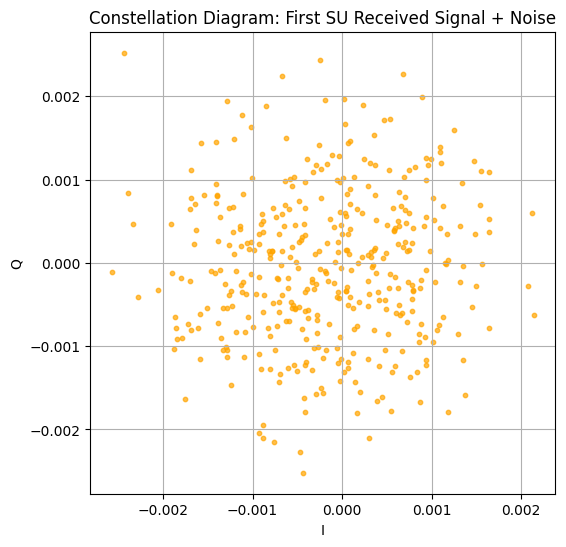

In [23]:
default_parameters['sigma2_avg'] = default_parameters['E_P_rxSU'] / (10**(default_parameters['SNR']/10))  # Average noise power per SU to achieve the target SNR
print("Average noise power per SU to achieve the target SNR:", default_parameters['sigma2_avg'], "Watts or ", 10*np.log10(default_parameters['sigma2_avg']*1000), "dBm" )



def check_sigma2_avg_update_needed(parameters):
    # Recalculate E_P_rxSU if any relevant parameters have changed
    relevant_params = ['P_txPU', 'r', 'd0', 'eta', 'sigma_s', 'xPU']
    if any(param in parameters for param in relevant_params):
        parameters['E_P_rxSU'] = CalcRXPower(parameters)
        parameters['sigma2_avg'] = parameters['E_P_rxSU'] / (10**(parameters['SNR']/10))
        print("Updated Expected value of received power at each SU (with shadowing):", parameters['E_P_rxSU'], "Watts")
        print("Updated Average noise power per SU to achieve the target SNR:", parameters['sigma2_avg'], "Watts or ", 10*np.log10(parameters['sigma2_avg']*1000), "dBm" )
    else:
        print("No relevant parameter changes detected. No update needed.")

def noise_su(parameters):
    U = np.random.uniform(-1, 1, parameters['m'])
    sigma2 = (1 + parameters['rho'] * U) * parameters['sigma2_avg']
    sqrtsigma2 = np.sqrt(sigma2/2)
    n = np.random.normal(0, sqrtsigma2, [parameters['n'], parameters['m']]) + 1j*np.random.normal(0, sqrtsigma2, [parameters['n'], parameters['m']])
    return n.T;

noise = noise_su(default_parameters)

# Received signal at first SU: channel effect * PU signal
rx_signal = combined_channel_complex[:, np.newaxis] * pu_samples
rx_signal_first_su = np.array(rx_signal[0] + noise[0]).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(np.real(rx_signal_first_su), np.imag(rx_signal_first_su), color='orange', s=10, alpha=0.7)
plt.title('Constellation Diagram: First SU Received Signal + Noise')
plt.xlabel('I')
plt.ylabel('Q')
plt.grid(True)
plt.show()


Detectors


In [24]:
E = 0.1;             # Inequality aversion parameter of the AID.

def calculate_GID(x_h0, x_h1):
    Num_h0=0
    Num_h1=0
    for u in range(x_h0.size):
        for j in range(u+1, x_h0.size): # Faster with j=u:m^2 instead of j=1:m^2 (sum of (m^4 + m^2)/2 terms, instead of m^4)
            Num_h0 = Num_h0 + np.abs(x_h0[u]-x_h0[j]);
            Num_h1 = Num_h1 + np.abs(x_h1[u]-x_h1[j]);
    Tgid_h0 = np.sum(np.abs(x_h0))/Num_h0;
    Tgid_h1 = np.sum(np.abs(x_h1))/Num_h1;

    return Tgid_h0[0,0], Tgid_h1[0,0]



def calculate_PRIDE(x_h0, x_h1):
    """Calculates the Pietra-Ricci Index Detector (PRIDE) statistic.

    The PRIDE statistic is a measure of inequality in a distribution.
    It is calculated as the ratio of the sum of absolute values in the
    distribution to the sum of absolute differences between each value
    and the mean of the distribution.

    Args:
        x_h0: Flattened received signal sample covariance matrix under H0.
        x_h1: Flattened received signal sample covariance matrix under H1.

    Returns:
        A tuple containing the PRIDE statistic under H0 and H1.
    """
    m0 = np.mean(x_h0);
    m1 = np.mean(x_h1);
    Tpride_h0 = np.sum(np.abs(x_h0))/np.sum(np.abs(x_h0 - m0));
    Tpride_h1 = np.sum(np.abs(x_h1))/np.sum(np.abs(x_h1 - m1));
    return Tpride_h0, Tpride_h1

## AID (Atkinson index detector) test statistic
def calculate_AID(R_h0, R_h1, E):
    """Calculates the Atkinson Index Detector (AID) statistic.

    The AID statistic is a measure of inequality in a distribution.
    It is a family of indices parameterized by E, reflecting the
    degree of inequality aversion.

    Args:
        R_h0: Received signal sample covariance matrix under H0.
        R_h1: Received signal sample covariance matrix under H1.
        E: Inequality aversion parameter.

    Returns:
        A tuple containing the AID statistic under H0 and H1.
    """
    m0 = np.mean(R_h0);
    m1 = np.mean(R_h1);
    if E==0.5:
        SUM0=0;
        SUM1=0;
        for ROW in range(m):
            for COL in range(ROW, m):
                I=COL==ROW;
                SUM0 = SUM0 + (2-I) * np.sqrt(np.abs(R_h0[ROW, COL]) + np.real(R_h0[ROW,COL]));
                SUM1 = SUM1 + (2-I) * np.sqrt(np.abs(R_h1[ROW, COL]) + np.real(R_h1[ROW,COL]));
        Taid_h0 = (SUM0**2)/m0;
        Taid_h1 = (SUM1**2)/m1;
    else:
        Taid_h0 = (np.float_power((np.sum(np.sum(np.float_power(R_h0,(1-E))))),(1/(1-E))))/m0; # Corrected on Nov/2024
        Taid_h1 = (np.float_power((np.sum(np.sum(np.float_power(R_h1,(1-E))))),(1/(1-E))))/m1; # Corrected on Nov/2024
    return np.abs(Taid_h0), np.abs(Taid_h1)


def calculate_HR(R_h0, R_h1):
    """
    Calculates the Hadamard Ratio (HR) statistic.

    Args:
        R_h0: Received signal sample covariance matrix under H0.
        R_h1: Received signal sample covariance matrix under H1.

    Returns:
        A tuple containing the HR statistic under H0 and H1.
    """
    Thr_h0 = -np.real(np.linalg.det(R_h0) / np.prod(np.diag(R_h0)))
    Thr_h1 = -np.real(np.linalg.det(R_h1) / np.prod(np.diag(R_h1)))
    return Thr_h0, Thr_h1

def calculate_VD1(R_h0, R_h1):
    """
    Calculates the Variance-Distance Ratio (VD1) statistic.

    Args:
        R_h0: Received signal sample covariance matrix under H0.
        R_h1: Received signal sample covariance matrix under H1.

    Returns:
        A tuple containing the VD1 statistic under H0 and H1.
    """

    # Preallocate arrays for dh0 and dh1
    M = R_h0.shape[0]
    dh0 = np.zeros(M)
    dh1 = np.zeros(M)

    # Compute norms for each row
    for j in range(M):
        dh0[j] = np.linalg.norm(R_h0[j, :])
        dh1[j] = np.linalg.norm(R_h1[j, :])

    # Create diagonal matrices
    DD_h0 = np.diag(dh0)
    DD_h1 = np.diag(dh1)

    # Compute Tvd1_h0 and Tvd1_h1
    Tvd1_h0 = -np.real(np.log(np.linalg.det(np.linalg.inv(DD_h0) @ R_h0)))
    Tvd1_h1 = -np.real(np.log(np.linalg.det(np.linalg.inv(DD_h1) @ R_h1)))

    return Tvd1_h0, Tvd1_h1

def calculate_LMPIT(R_h0, R_h1):
    """
    Calculates the Locally Most Powerful Invariant Test (LMPIT) statistic.

    Args:
        R_h0: Received signal sample covariance matrix under H0.
        R_h1: Received signal sample covariance matrix under H1.

    Returns:
        A tuple containing the LMPIT statistic under H0 and H1.
    """

    # Diagonal matrices
    D_h0 = np.diag(np.diag(R_h0))
    D_h1 = np.diag(np.diag(R_h1))

    # Matrix normalization
    D_h0_inv_sqrt = np.linalg.inv(np.sqrt(D_h0))
    D_h1_inv_sqrt = np.linalg.inv(np.sqrt(D_h1))

    C_h0 = D_h0_inv_sqrt @ R_h0 @ D_h0_inv_sqrt
    C_h1 = D_h1_inv_sqrt @ R_h1 @ D_h1_inv_sqrt

    # Compute Frobenius norm squared
    Tlmpit_h0 = np.linalg.norm(C_h0, 'fro')**2
    Tlmpit_h1 = np.linalg.norm(C_h1, 'fro')**2

    return Tlmpit_h0, Tlmpit_h1

def calculate_MMED(lambda_h0, lambda_h1):
    """
    Calculates the Maximum-Minimum Eigenvalue Detector (MMED) statistic.

    Args:
        lambda_h0: Eigenvalues of the received signal sample covariance matrix under H0.
        lambda_h1: Eigenvalues of the received signal sample covariance matrix under H1.

    Returns:
        A tuple containing the MMED statistic under H0 and H1.
    """

    Tmmed_h0 = lambda_h0[0]/lambda_h0[-1]
    Tmmed_h1 = lambda_h1[0]/lambda_h1[-1]

    return Tmmed_h0, Tmmed_h1


def calculate_SLE(lambda_h0, lambda_h1):
    """
    Calculates the Generalized Likelihood Ratio Test (sle) statistic.

    Args:
        lambda_h0: Eigenvalues of the received signal sample covariance matrix under H0.
        lambda_h1: Eigenvalues of the received signal sample covariance matrix under H1.

    Returns:
        A tuple containing the sle statistic under H0 and H1.
    """

    Tsle_h0 = lambda_h0[0]/np.sum(lambda_h0[1:-1]);
    Tsle_h1 = lambda_h1[0]/np.sum(lambda_h1[1:-1]);
    return Tsle_h0, Tsle_h1


def calculate_AGM(lambda_h0, lambda_h1):
    """
    Calculates the Arithmetic-Geometric Mean (AGM) statistic.

    Args:
        lambda_h0: Eigenvalues of the received signal sample covariance matrix under H0.
        lambda_h1: Eigenvalues of the received signal sample covariance matrix under H1.

    Returns:
        A tuple containing the AGM statistic under H0 and H1.
    """
    Tagm_h0 = np.sum(lambda_h0)/((np.prod(lambda_h0))**(1/lambda_h0.size**2));
    Tagm_h1 = np.sum(lambda_h1)/((np.prod(lambda_h1))**(1/lambda_h1.size**2));
    return Tagm_h0, Tagm_h1


def calculate_MSEE(lambda_h0, lambda_h1):
    """
    Calculates the Mean-to-Square Extreme Eigenvalue (MSEE) statistic.

    Args:
        lambda_h0: Eigenvalues of the received signal sample covariance matrix under H0.
        lambda_h1: Eigenvalues of the received signal sample covariance matrix under H1.

        Returns:
        A tuple containing the MSEE statistic under H0 and H1.
    """
    Tmsee_h0 = (lambda_h0[0]+lambda_h0[-1])/np.sqrt(lambda_h0[0]*lambda_h0[-1]);
    Tmsee_h1 = (lambda_h1[0]+lambda_h1[-1])/np.sqrt(lambda_h1[0]*lambda_h1[-1]);
    return Tmsee_h0, Tmsee_h1

def calculate_TID(R_h0, R_h1):
    m = R_h0.shape[0]
    r_abs_h0 = np.sum(np.abs(R_h0))
    r_abs_h1 = np.sum(np.abs(R_h1))
    SUM0=0
    SUM1=0
    for ROW in range(m):
        for COL in range(ROW, m):
            I=COL==ROW
            SUM0 = SUM0 + (2-I) * np.abs(R_h0[ROW, COL]) * np.log(np.abs(R_h0[ROW,COL])/r_abs_h0)
            SUM1 = SUM1 + (2-I) * np.abs(R_h1[ROW, COL]) * np.log(np.abs(R_h1[ROW,COL])/r_abs_h1)
    Ttid_h0 = 1/SUM0
    Ttid_h1 = 1/SUM1
    return Ttid_h0, Ttid_h1



def calculate_metrics(rx_signal_h0, rx_signal_h1):
    """
    Calculates various detection metrics based on the received signal under two hypotheses.

    Args:
        rx_signal_h0: Received signal under hypothesis H0.
        rx_signal_h1: Received signal under hypothesis H1.

    Returns:
        A dictionary containing the calculated metrics.
    """
    X_h0 = np.matrix(rx_signal_h0)
    X_h1 = np.matrix(rx_signal_h1)


    # Sample covariance matrices
    if(X_h0.shape[1] == 1):
        R_h0 = (X_h0 @ X_h0.conj().T) /X_h0.shape[1]  # TODO
        R_h1 = (X_h1 @ X_h1.conj().T) / X_h1.shape[1] # TODO
    else:
        R_h0 = (X_h0 @ X_h0.conj().T) /X_h0.shape[1]
        R_h1 = (X_h1 @ X_h1.conj().T) / X_h1.shape[1]

    # Eigenvalues
    lambda_h0 = np.linalg.eigvalsh(R_h0)[::-1]  # Sorted in descending order
    lambda_h1 = np.linalg.eigvalsh(R_h1)[::-1]  # Sorted in descending order

    # Flattened received signal sample covariance matrices
    x_h0 = R_h0.flatten().reshape(-1, 1)
    x_h1 = R_h1.flatten().reshape(-1, 1)

    # Calculate metrics
    Tgid_h0, Tgid_h1 = calculate_GID(x_h0, x_h1)
    Tpride_h0, Tpride_h1 = calculate_PRIDE(x_h0, x_h1)
    Taid_h0, Taid_h1 = calculate_AID(R_h0, R_h1, E)  # Example with E=0.5
    Thr_h0, Thr_h1 = calculate_HR(R_h0, R_h1)
    Tvd1_h0, Tvd1_h1 = calculate_VD1(R_h0, R_h1)
    Tlmpit_h0, Tlmpit_h1 = calculate_LMPIT(R_h0, R_h1)
    Tmmed_h0, Tmmed_h1 = calculate_MMED(lambda_h0, lambda_h1)
    Tsle_h0, Tsle_h1 = calculate_SLE(lambda_h0, lambda_h1)
    Tagm_h0, Tagm_h1 = calculate_AGM(lambda_h0, lambda_h1)
    Tmsee_h0, Tmsee_h1 = calculate_MSEE(lambda_h0, lambda_h1)
    Ttid_h0, Ttid_h1 = calculate_TID(R_h0, R_h1)

    return {
        'GID': (Tgid_h0, Tgid_h1),
        'PRIDE': (Tpride_h0, Tpride_h1),
        'AID': (Taid_h0, Taid_h1),
        'HR': (Thr_h0, Thr_h1),
        'VD1': (Tvd1_h0, Tvd1_h1),
        'LMPIT': (Tlmpit_h0, Tlmpit_h1),
        'MMED': (Tmmed_h0, Tmmed_h1),
        'SLE': (Tsle_h0, Tsle_h1),
        'AGM': (Tagm_h0, Tagm_h1),
        'MSEE': (Tmsee_h0, Tmsee_h1),
        'TID': (Ttid_h0, Ttid_h1)
    }

curve_styles = {
    'GID':   dict(fmt='c-o',  linewidth=2.5, markerfacecolor='k', markersize=7, label='GID'),
    'PRIDE': dict(fmt='m-h',  linewidth=2.5, markerfacecolor='w', markersize=7, label='PRIDe'),
    'AID':   dict(fmt='r-s',  linewidth=2.5, markerfacecolor='w', markersize=7, label='AID'),
    'HR':    dict(fmt='k-o',  linewidth=2.5, markerfacecolor='w', markersize=7, label='HR'),
    'VD1':   dict(fmt='b-^',  linewidth=2.5, markerfacecolor='w', markersize=7, label='VD1'),
    'SLE':   dict(fmt='y-->', linewidth=2.5, markerfacecolor='b', markersize=7, label='SLE'),
    'MMED':  dict(fmt='r--<', linewidth=2.5, markerfacecolor='w', markersize=7, label='MMED'),
    'AGM':   dict(fmt='b--p', linewidth=2.5, markerfacecolor='w', markersize=7, label='AGM'),
    'LMPIT': dict(fmt='m-*',  linewidth=2.5, markerfacecolor='w', markersize=7, label='LMPIT'),
    'MSEE':  dict(fmt='k--v', linewidth=2.5, markerfacecolor='w', markersize=7, label='MSEE'),
    'TID':   dict(fmt='g-D',  linewidth=2.5, markerfacecolor='w', markersize=7, label='TID')
}

metrics = calculate_metrics(noise, rx_signal+noise)
for metric, values in metrics.items():
    print(f"{metric} - H0: {values[0]}, H1: {values[1]}")




GID - H0: 0.05145863122785045, H1: 0.05527428471903961
PRIDE - H0: 0.7397255937756176, H1: 0.8513967161442185
AID - H0: 29.77084974895834, H1: 32.14939017599184
HR - H0: -0.9696410828590744, H1: -0.9194530511295705
VD1 - H0: 0.06291260697570486, H1: 0.17126685820796136
LMPIT - H0: 5.060958124113279, H1: 5.169793189012666
MMED - H0: 1.9743862123401026, H1: 2.4285353678228856
SLE - H0: 0.460080998045007, H1: 0.5663984594728941
AGM - H0: 0.00010865148593964612, H1: 0.0001201787028564339
MSEE - H0: 2.1168072022308055, H1: 2.2000695870590503
TID - H0: -49640.43495185766, H1: -40146.170270403185


Direct Conversion Receiver Effects

In [25]:
def moving_average_filter(samples, parameters):
    if parameters['L'] <= 1:
        return samples
    L = parameters['L']
    h = np.ones(L) / np.sqrt(L)

    for su in range(parameters['m']):
        samples[su] = np.convolve(np.asarray(samples[su]).flatten(), h, mode='same')[:samples.shape[1]]

    return samples

def whitening_matrix(parameters):
    L = parameters['L']
    a = np.zeros(parameters['n'])
    a[:L] = 1 - np.arange(L)/L
    Q = scipy.linalg.toeplitz(a)
    L_c = np.linalg.cholesky(Q)
    W = np.linalg.inv(L_c)  # whitening matrix
    return W.T

def whitening(samples, parameters):
    if parameters['L'] <= 1:
        return samples
    samples = np.array(samples).flatten()
    return (samples @ parameters['W_matrix'])

def gen_dc_offset(parameters):
    sigma2_dc = parameters['sigma2_dc']
    D = np.zeros((parameters['m'], parameters['n']), dtype=complex)
    for i in range(parameters['m']):
        D[i,:] = np.sqrt(sigma2_dc/2)*(np.random.randn() + 1j*np.random.randn())
    return D

def agc(samples, parameters):

    Y_out = np.empty_like(samples)
    for i in range(parameters['m']):
        g_i = parameters['fod'] * np.sqrt(2*parameters['n']) / (6*np.linalg.norm(samples[i,:]))
        Y_out[i,:] = g_i * samples[i,:]
    return Y_out

def quantize(samples, parameters):
    clip_range = parameters['clip_range']
    Nq_bits = parameters['Nq_bits']
    N = 2**Nq_bits
    delta = 2*clip_range / N
    def qfun(x):
        idx = np.floor((np.clip(x, -clip_range, clip_range) + clip_range)/delta + 0.5)
        return -clip_range + idx*delta
    return qfun(np.real(samples)) + 1j*qfun(np.imag(samples))

default_parameters['W_matrix'] = whitening_matrix(default_parameters)


Simulation Routine

Simulating for parameter: meanK
  Running with meanK = -10.0      {'sdK': 4.13, 'randK': True, 'm': 5, 'eta': 2.5, 'n': 400, 'SNR': -5, 'rho': 0, 'Ns': 15, 'E': 0.1, 'sigma_s': 7, 'rows': 50, 'Lambda': 25, 'r': 1000, 'xPU': 1000, 'P_txPU': 5, 'd0': 1, 'runs': 1000, 'Pfa': 0.1, 'L': 1, 'SDCR_dB': inf, 'fod': 0, 'Nq_bits': 0, 'clip_range': 1}


IntProgress(value=0, max=999)

  Running with meanK = -7.142857142857142      {'sdK': 4.13, 'randK': True, 'm': 5, 'eta': 2.5, 'n': 400, 'SNR': -5, 'rho': 0, 'Ns': 15, 'E': 0.1, 'sigma_s': 7, 'rows': 50, 'Lambda': 25, 'r': 1000, 'xPU': 1000, 'P_txPU': 5, 'd0': 1, 'runs': 1000, 'Pfa': 0.1, 'L': 1, 'SDCR_dB': inf, 'fod': 0, 'Nq_bits': 0, 'clip_range': 1, 'sigma2_dc': 0}


IntProgress(value=0, max=999)

  Running with meanK = -4.285714285714286      {'sdK': 4.13, 'randK': True, 'm': 5, 'eta': 2.5, 'n': 400, 'SNR': -5, 'rho': 0, 'Ns': 15, 'E': 0.1, 'sigma_s': 7, 'rows': 50, 'Lambda': 25, 'r': 1000, 'xPU': 1000, 'P_txPU': 5, 'd0': 1, 'runs': 1000, 'Pfa': 0.1, 'L': 1, 'SDCR_dB': inf, 'fod': 0, 'Nq_bits': 0, 'clip_range': 1, 'sigma2_dc': 0}


IntProgress(value=0, max=999)

  Running with meanK = -1.4285714285714288      {'sdK': 4.13, 'randK': True, 'm': 5, 'eta': 2.5, 'n': 400, 'SNR': -5, 'rho': 0, 'Ns': 15, 'E': 0.1, 'sigma_s': 7, 'rows': 50, 'Lambda': 25, 'r': 1000, 'xPU': 1000, 'P_txPU': 5, 'd0': 1, 'runs': 1000, 'Pfa': 0.1, 'L': 1, 'SDCR_dB': inf, 'fod': 0, 'Nq_bits': 0, 'clip_range': 1, 'sigma2_dc': 0}


IntProgress(value=0, max=999)

  Running with meanK = 1.4285714285714288      {'sdK': 4.13, 'randK': True, 'm': 5, 'eta': 2.5, 'n': 400, 'SNR': -5, 'rho': 0, 'Ns': 15, 'E': 0.1, 'sigma_s': 7, 'rows': 50, 'Lambda': 25, 'r': 1000, 'xPU': 1000, 'P_txPU': 5, 'd0': 1, 'runs': 1000, 'Pfa': 0.1, 'L': 1, 'SDCR_dB': inf, 'fod': 0, 'Nq_bits': 0, 'clip_range': 1, 'sigma2_dc': 0}


IntProgress(value=0, max=999)

  Running with meanK = 4.2857142857142865      {'sdK': 4.13, 'randK': True, 'm': 5, 'eta': 2.5, 'n': 400, 'SNR': -5, 'rho': 0, 'Ns': 15, 'E': 0.1, 'sigma_s': 7, 'rows': 50, 'Lambda': 25, 'r': 1000, 'xPU': 1000, 'P_txPU': 5, 'd0': 1, 'runs': 1000, 'Pfa': 0.1, 'L': 1, 'SDCR_dB': inf, 'fod': 0, 'Nq_bits': 0, 'clip_range': 1, 'sigma2_dc': 0}


IntProgress(value=0, max=999)

  Running with meanK = 7.142857142857142      {'sdK': 4.13, 'randK': True, 'm': 5, 'eta': 2.5, 'n': 400, 'SNR': -5, 'rho': 0, 'Ns': 15, 'E': 0.1, 'sigma_s': 7, 'rows': 50, 'Lambda': 25, 'r': 1000, 'xPU': 1000, 'P_txPU': 5, 'd0': 1, 'runs': 1000, 'Pfa': 0.1, 'L': 1, 'SDCR_dB': inf, 'fod': 0, 'Nq_bits': 0, 'clip_range': 1, 'sigma2_dc': 0}


IntProgress(value=0, max=999)

  Running with meanK = 10.0      {'sdK': 4.13, 'randK': True, 'm': 5, 'eta': 2.5, 'n': 400, 'SNR': -5, 'rho': 0, 'Ns': 15, 'E': 0.1, 'sigma_s': 7, 'rows': 50, 'Lambda': 25, 'r': 1000, 'xPU': 1000, 'P_txPU': 5, 'd0': 1, 'runs': 1000, 'Pfa': 0.1, 'L': 1, 'SDCR_dB': inf, 'fod': 0, 'Nq_bits': 0, 'clip_range': 1, 'sigma2_dc': 0}


IntProgress(value=0, max=999)

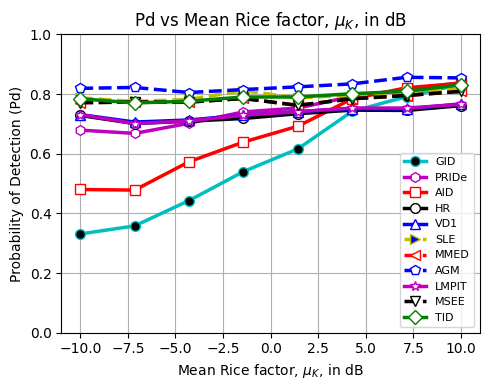

In [26]:
plot_statistics = False;    # If plot_statistics, plot the test statistics for.
plot_histogram = False;     # If plot_histogram, plot histograms of the test statistics.
plot_roc = False;           # If plot_roc, plot ROC curves.

temp_parameters = ['shadow_L_matrix', 'E_P_rxSU', 'sigma2_avg', 'W_matrix']

for param in parameter_infos.values():
    param.simulate = False

parameter_infos['meanK'].simulate = True
#parameter_infos['SDCR_dB'].simulate = True
#parameter_infos['L'].simulate = True
#parameter_infos['eta'].simulate = True

parameter_infos['rho'].default = 0
# parameter_infos['r'].default = 1
# parameter_infos['xPU'].default = 1
# parameter_infos['d0'].default = 0.001


# parameter_infos['m'].default = 6
# parameter_infos['n'].default = 250
# parameter_infos['SNR'].default = -10
# parameter_infos['rows'].default = 0
# parameter_infos['Ns'].default = 25

# parameter_infos['SDCR_dB'].default = 5
# parameter_infos['L'].default = 25
# parameter_infos['fod'].default = 1.2
# parameter_infos['Nq_bits'].default = 3

def iteration(parameters):
    pu_pos = np.array([parameters['xPU'], parameters['xPU']])
    su_pos = generate_su(parameters['m'], parameters['r'])
    pu_samples = qpsk(parameters['n'], parameters['Ns']) * np.sqrt(parameters['P_txPU']/2)

    combined_channel_complex = get_combined_channel_complex(pu_pos, su_pos, parameters)[:, np.newaxis]
    rx_signal = combined_channel_complex @ pu_samples

    noise = noise_su(parameters)

    sensored_rx_signal = rx_signal + noise

    if parameters['L'] > 1:
        sensored_rx_signal = moving_average_filter(sensored_rx_signal, parameters)
        noise = moving_average_filter(noise, parameters)

    if parameters['sigma2_dc'] > 0:
        dc_samples = gen_dc_offset(parameters)
        sensored_rx_signal += dc_samples
        noise += dc_samples

    if parameters['fod'] > 0:
        sensored_rx_signal = agc(sensored_rx_signal, parameters)
        noise = agc(noise, parameters)

    if parameters['Nq_bits'] > 0:
        sensored_rx_signal = quantize(sensored_rx_signal, parameters)
        noise = quantize(noise, parameters)


    if parameters['L'] > 1:
        for su in range(parameters['m']):
            sensored_rx_signal[su] = whitening(sensored_rx_signal[su], parameters)
            noise[su] = whitening(noise[su], parameters)

    metrics = calculate_metrics(noise, sensored_rx_signal)
    return metrics


for parameter_name, parameter in parameter_infos.items():
    if parameter.simulate:
        print(f"Simulating for parameter: {parameter_name}")
        results = {key: {'H0': [], 'H1': [], 'H0_min': [], 'H0_max': [], 'H1_min': [], 'H1_max': [], 'Pd': [], 'Threshold': []} for key in curve_styles.keys()}


        current_parameters = {key: parameter.default for key, parameter in parameter_infos.items()}

        current_parameters['E_P_rxSU'] = CalcRXPower(current_parameters)
        current_parameters['shadow_L_matrix'] = Shadowing_L_matrix(current_parameters['rows'], current_parameters['Lambda'])
        current_parameters['W_matrix'] = whitening_matrix(current_parameters)

        for idx, value in enumerate(parameter.variation):
            current_parameters[parameter_name] = value

            print(f"  Running with {parameter_name} = {value}", "    ", {k: v for k, v in current_parameters.items() if k not in [parameter_name, *temp_parameters]})

            all_metrics = {key: {'H0': [], 'H1': []} for key in curve_styles.keys()}

            f = IntProgress(min=0, max=current_parameters['runs']-1)
            display(f)

            if parameter_name in ['r', 'xPU', 'eta', 'P_txPU', 'd0', 'sigma_s']:
                current_parameters['E_P_rxSU'] = CalcRXPower(current_parameters)

            current_parameters['sigma2_avg'] = current_parameters['E_P_rxSU'] / (10**(current_parameters['SNR']/10))  # Average noise power per SU to achieve the target SNR
            current_parameters['sigma2_dc'] = 0 if current_parameters['SDCR_dB'] == np.inf else current_parameters['E_P_rxSU'] / (10**(current_parameters['SDCR_dB']/10))

            if parameter_name in ['rows', 'Lambda']:
                current_parameters['shadow_L_matrix'] = Shadowing_L_matrix(current_parameters['rows'], current_parameters['Lambda'])

            if parameter_name in ['L', 'n']:
                current_parameters['W_matrix'] = whitening_matrix(current_parameters)



            for _ in range(current_parameters['runs']):
                f.value += 1 # signal to increment the progress bar
                metrics = iteration(current_parameters)
                for key, values in metrics.items():
                    all_metrics[key]['H0'].append(values[0])
                    all_metrics[key]['H1'].append(values[1])

            f.close()

            for key in results.keys():
                results[key]['H0'].append(np.mean(all_metrics[key]['H0']))
                results[key]['H1'].append(np.mean(all_metrics[key]['H1']))

                # Calculate probability of detection (Pd) for the current metric and parameter value
                # Use the empirical distributions of H0 and H1 for thresholding at reference Pfa
                # Find threshold for reference Pfa
                threshold = np.percentile(np.array(all_metrics[key]['H0']), 100 * (1 - current_parameters['Pfa']))
                # Pd: fraction of H1 samples above threshold
                Pd = np.mean(np.array(all_metrics[key]['H1']) > threshold)

                results[key]['Pd'].append(Pd)
                results[key]['Threshold'].append(threshold)

                if plot_statistics:
                    results[key]['H0_min'].append(np.min(all_metrics[key]['H0']))
                    results[key]['H0_max'].append(np.max(all_metrics[key]['H0']))
                    results[key]['H1_min'].append(np.min(all_metrics[key]['H1']))
                    results[key]['H1_max'].append(np.max(all_metrics[key]['H1']))


            if plot_roc:
                # Calculate ROC curves for each statistic
                fig_roc, ax_roc = plt.subplots(figsize=(5, 4))
                for key in results.keys():
                    h0 = np.array(all_metrics[key]['H0'])
                    h1 = np.array(all_metrics[key]['H1'])
                    thresholds = np.percentile(np.array(all_metrics[key]['H0']), 100 * np.linspace(0, 1, 20))
                    Pfa_roc = []
                    Pd_roc = []
                    for t in thresholds:
                        Pfa_roc.append(np.mean(h0 > t))
                        Pd_roc.append(np.mean(h1 > t))
                    ax_roc.plot(Pfa_roc, Pd_roc, curve_styles[key]['fmt'], linewidth=curve_styles[key]['linewidth'],
                                markerfacecolor=curve_styles[key]['markerfacecolor'], markersize=curve_styles[key]['markersize'],
                                label=curve_styles[key]['label'])

                ax_roc.set_xlabel('Probability of False Alarm (Pfa)')
                ax_roc.set_ylabel('Probability of Detection (Pd)')
                ax_roc.set_title(f'ROC Curve for {parameter.name} = {value}')
                ax_roc.set_xlim([0, 1])
                ax_roc.set_ylim([0, 1])
                ax_roc.grid(True)
                ax_roc.legend(loc='lower right', fontsize=8, frameon=True)
                plt.tight_layout()
                plt.show()

            if plot_histogram:
                nr_statistics = len(results.keys())
                fig = plt.figure(figsize=(18, 7))
                nr_cols = np.min([nr_statistics + 1, 6])
                nr_rows = int(np.ceil((nr_statistics + 1) / (nr_cols)))

                gs = fig.add_gridspec(nr_rows, nr_cols)
                axs_hist = []
                for gsi in gs:
                    axs_hist.append(fig.add_subplot(gsi))

                legend_handles_hist = []
                legend_labels_hist = []
                for idx, key in enumerate(results.keys()):
                    ax_hist = axs_hist[idx]
                    # Use the last run's h0, h1, threshold for this key
                    ax_hist.hist(np.array(all_metrics[key]['H0']), bins=30, alpha=0.6, label='H0', color='tab:blue', density=True)
                    ax_hist.hist(np.array(all_metrics[key]['H1']), bins=30, alpha=0.6, label='H1', color='tab:orange', density=True)
                    ax_hist.axvline(np.array(results[key]['Threshold'][-1]), color='k', linestyle='--', label='Threshold')
                    ax_hist.set_title(f'{key}', fontsize=10)
                    ax_hist.set_xlabel(f'{key} Statistic', fontsize=8)
                    ax_hist.set_ylabel('Density', fontsize=8)
                    ax_hist.grid(True)
                    ax_hist.tick_params(axis='both', which='major', labelsize=8)
                    ax_hist.tick_params(axis='both', which='minor', labelsize=6)
                    if idx == 0:
                        # Only collect legend handles/labels from the first subplot
                        handles, labels = ax_hist.get_legend_handles_labels()
                        legend_handles_hist = handles
                        legend_labels_hist = labels

                axs_hist[-1].axis('off')
                axs_hist[-1].legend(legend_handles_hist, legend_labels_hist, loc='upper center', fontsize=10, frameon=True)

                plt.tight_layout()
                plt.show()

        if plot_statistics:
            nr_statistics = len(results.keys())
            fig = plt.figure(figsize=(18, 7))
            nr_cols = np.min([nr_statistics + 1, 6])
            nr_rows = int(np.ceil((nr_statistics + 1) / (nr_cols)))

            gs = fig.add_gridspec(nr_rows, nr_cols)
            axs = []
            for gsi in gs:
                axs.append(fig.add_subplot(gsi))

            legend_handles = []
            legend_labels = []
            for idx, key in enumerate(results.keys()):
                ax = axs[idx]
                h0_line, = ax.plot(parameter.variation, results[key]['H0'], marker='o', label=f'H0 avg')
                h1_line, = ax.plot(parameter.variation, results[key]['H1'], marker='s', label=f'H1 avg')

                # Plot min and max values as error bars
                h0_line_max = ax.errorbar(parameter.variation, results[key]['H0'], yerr=[np.zeros_like(results[key]['H0']), np.array(results[key]['H0_max']) - np.array(results[key]['H0'])], fmt=' ', color='tab:blue', alpha=0.5, capsize=3, label=f'H0 max')
                h1_line_min = ax.errorbar(parameter.variation, results[key]['H1'], yerr=[np.array(results[key]['H1']) - np.array(results[key]['H1_min']), np.zeros_like(results[key]['H1'])], fmt=' ', color='tab:orange', alpha=0.5, capsize=3, label=f'H1 min')
                threshold_line, = ax.plot(parameter.variation, results[key]['Threshold'], 'k--', linewidth=1.0, label='Decision Threshold')

                ax.set_xlabel(parameter.xlabel, fontsize=8)
                ax.set_ylabel(f'{key} Statistic', fontsize=8)
                ax.set_title(f'{key}', fontsize=10)
                if parameter.xticks is not None:
                    ax.set_xticks(parameter.xticks)
                ax.grid(True)
                ax.tick_params(axis='both', which='major', labelsize=8)
                ax.tick_params(axis='both', which='minor', labelsize=6)
                # Collect legend handles/labels from the first subplot only
                if idx == 0:
                    legend_handles = [h0_line, h0_line_max, h1_line, h1_line_min, threshold_line]
                    legend_labels = ['H0 avg', 'H0 max', 'H1 avg', 'H1 min', 'Decision Threshold']

            axs[-1].axis('off')
            axs[-1].legend(legend_handles, legend_labels, loc='upper center', fontsize=10, frameon=True)

            plt.tight_layout()
            plt.show()

        # Plot Pd vs parameter
        plt.figure(figsize=(5, 4))
        for key in curve_styles.keys():
            plt.plot(parameter.variation, results[key]['Pd'], curve_styles[key]['fmt'], linewidth=curve_styles[key]['linewidth'], markerfacecolor=curve_styles[key]['markerfacecolor'], markersize=curve_styles[key]['markersize'], label=curve_styles[key]['label'])

        plt.ylim(0, 1)
        plt.xlabel(parameter.xlabel)
        plt.ylabel('Probability of Detection (Pd)')
        plt.title('Pd vs ' + parameter.xlabel)
        plt.legend(fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
